In [1]:
import cv2
import numpy as np
import os


# Get the training classes names and store them in a list
#Here we use folder names for class names

#train_path = 'dataset/train'  # Names are Aeroplane, Bicycle, Car
train_path = r'C:\MLAI\Coursework\IVC\Coursework\marvel\train'  # Folder Names are Parasitized and Uninfected
training_names = os.listdir(train_path)


# Get path to all images and save them in a list
# image_paths and the corresponding label in image_paths
image_paths = []
image_classes = []
class_id = 0

#To make it easy to list all file names in a directory let us define a function
#
def imglist(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

#Fill the placeholder empty lists with image path, classes, and add class ID number
#
    
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    if '.DS_Store' not in dir:
        class_path = imglist(dir)
        image_paths+=class_path
        image_classes+=[class_id]*len(class_path)
        class_id+=1

# Create feature extraction and keypoint detector objects
    #SIFT is not available anymore in openCV    
# Create List where all the descriptors will be stored
des_list = []

#BRISK is a good replacement to SIFT. ORB also works but didn;t work well for this example
brisk = cv2.SIFT_create()



In [36]:
for image_path in image_paths:
    im = cv2.imread(image_path)
    im = cv2.resize(im, (128, 128)) 
    kpts, des = brisk.detectAndCompute(im, None)
    des_list.append((image_path, des))   

In [37]:
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))  

#kmeans works only on float, so convert integers to float

In [38]:
descriptors_float = descriptors.astype(float)  

# Perform k-means clustering and vector quantization
from scipy.cluster.vq import kmeans, vq

k = 200  #k means with 100 clusters gives lower accuracy for the aeroplane example
voc, variance = kmeans(descriptors_float, k, 1) 

In [42]:
# Calculate the histogram of features and represent them as vector
#vq Assigns codes from a code book to observations.
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1

In [44]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

In [45]:
# Scaling the words
#Standardize features by removing the mean and scaling to unit variance
#In a way normalization
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [46]:
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
# Train the Linear SVM
from sklearn.svm import LinearSVC
clf = LinearSVC(max_iter=10000)  #Default of 100 is not converging
clf.fit(im_features, np.array(image_classes))

#Train Random forest to compare how it does against SVM
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(n_estimators = 100, random_state=30)
#clf.fit(im_features, np.array(image_classes))

c:\MLAI\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=10000)

In [47]:
import joblib
training_names.remove

<function list.remove(value, /)>

In [48]:
# Save the SVM
#Joblib dumps Python object into one file
# from sklearn.externals import joblib
joblib.dump((clf, training_names, stdSlr, k, voc), "bovw.pkl", compress=3) 

['bovw.pkl']

## Testing

In [2]:
import cv2
import numpy as np
import os
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score #sreeni
import joblib
import os.path
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score
import pickle

In [3]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
#from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = joblib.load("bovw.pkl")

In [4]:
def onehot(label):

    le = preprocessing.LabelEncoder()
    labels_classes = le.fit_transform(label)
    labels_classes = pd.Series(labels_classes, name='Label')
    return labels_classes

In [5]:
# Dataset location
image_dir = Path('C:\MLAI\Coursework\IVC\Coursework\marvel')


# Storing path and label values
filepaths = list(image_dir.glob(r'valid\**\*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


# Creating dataframe object
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = onehot(labels)
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
path1 = r'C:\MLAI\Coursework\IVC\Coursework\marvel\marvel\valid\valid'

In [13]:
import skimage

In [18]:
def saltandpepper(input_img,sd):

    fact = [0.08,0.10,0.12,0.14,0.16,0.18]

    return skimage.util.random_noise(input_img, mode='s&p', seed=None, clip=True,amount = fact[sd])

In [19]:
saltandpepper_f1 = {}

In [ ]:
for per_value in range(0,10,1):

    for img_idx in range(len(image_df)):

        input_img1 = cv2.imread(image_df['Filepath'][img_idx],0)
        input_img1 = saltandpepper(input_img1,per_value)
        dir = os.path.split(image_df['Filepath'][img_idx])[0].split('\\')[-1]
        
        cv2.imwrite(path1+'\\'+dir+'\\'+os.path.split(image_df['Filepath'][img_idx])[1],input_img1)

    test_path = r'C:\MLAI\Coursework\IVC\Coursework\marvel\marvel\valid\valid'  # Folder Names are Parasitized and Uninfected
    #instead of test if you use train then we get great accuracy

    testing_names = os.listdir(test_path)

    # Get path to all images and save them in a list
    # image_paths and the corresponding label in image_paths
    image_paths = []
    image_classes = []
    class_id = 0

    def imglist(path):
        return [os.path.join(path, f) for f in os.listdir(path)]

    #Fill the placeholder empty lists with image path, classes, and add class ID number

    for testing_name in testing_names:
        dir = os.path.join(test_path, testing_name)
        if '.DS_Store' not in dir:
            class_path = imglist(dir)
            image_paths+=class_path
            image_classes+=[class_id]*len(class_path)
            class_id+=1

    des_list = []

    for image_path in image_paths:
        im = cv2.imread(image_path)
        kpts, des = brisk.detectAndCompute(im, None)
        des_list.append((image_path, des))  

    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[0:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    from scipy.cluster.vq import vq    
    test_features = np.zeros((len(image_paths), 200), "float32")
    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            test_features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

    test_features = stdSlr.transform(test_features)


    true_class = []
    predictions=[]
 

    true_class =  [classes_names[i] for i in image_classes]

    predictions =  [classes_names[i] for i in clf.predict(test_features)]

    
    saltandpepper_f1[str(per_value)] = f1_score(true_class,predictions,average=None)

In [ ]:
saltandpepper_f1

{'0': array([0.15625   , 0.18055556, 0.05      , 0.27272727, 0.31693989,
        0.125     , 0.29473684, 0.14634146]),
 '1': array([0.140625  , 0.17808219, 0.05      , 0.25688073, 0.32402235,
        0.125     , 0.3125    , 0.16666667]),
 '2': array([0.15503876, 0.19178082, 0.07407407, 0.25454545, 0.31693989,
        0.12987013, 0.31914894, 0.17073171]),
 '3': array([0.15503876, 0.18055556, 0.05128205, 0.25454545, 0.32432432,
        0.12658228, 0.3125    , 0.14814815]),
 '4': array([0.12698413, 0.16551724, 0.04938272, 0.26785714, 0.32044199,
        0.12820513, 0.30107527, 0.13953488]),
 '5': array([0.13953488, 0.19047619, 0.04938272, 0.25688073, 0.31638418,
        0.125     , 0.33333333, 0.1686747 ]),
 '6': array([0.140625  , 0.20689655, 0.07228916, 0.2962963 , 0.32967033,
        0.12345679, 0.30107527, 0.12195122]),
 '7': array([0.128     , 0.16326531, 0.05      , 0.27522936, 0.29189189,
        0.12820513, 0.32653061, 0.175     ]),
 '8': array([0.15625   , 0.18705036, 0.06818182,

In [ ]:
with open(r'svm_f1\saltandpepper_f1.pkl', 'wb') as f:
    pickle.dump(saltandpepper_f1, f)

In [72]:
for k in range(len(image_df)):

        input_img1 = cv2.imread(image_df['Filepath'][k],0)
        input_img1 = gaussian_noise(input_img1,0)
        dir = os.path.split(image_df['Filepath'][k])[0].split('\\')[-1]
        
        cv2.imwrite(path1+'\\'+dir+'\\'+os.path.split(image_df['Filepath'][k])[1],input_img1)

In [73]:

test_path = r'C:\MLAI\Coursework\IVC\Coursework\marvel\marvel\valid\valid' 


testing_names = os.listdir(test_path)

image_paths = []
image_classes = []
class_id = 0


In [74]:
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]


for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    if '.DS_Store' not in dir:
        class_path = imglist(dir)
        image_paths+=class_path
        image_classes+=[class_id]*len(class_path)
        class_id+=1


In [75]:
brisk = cv2.SIFT_create()

In [76]:
des_list = []

for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = brisk.detectAndCompute(im, None)
    des_list.append((image_path, des))   
    
# Stack all the descriptors vertically in a numpy array
# print(des_list)

In [77]:
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor)) 

# Calculate the histogram of features
#vq Assigns codes from a code book to observations

In [81]:
from scipy.cluster.vq import vq    
test_features = np.zeros((len(image_paths), 200), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        test_features[i][w] += 1

In [82]:
k

450

In [83]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

# Scale the features
#Standardize features by removing the mean and scaling to unit variance
#Scaler (stdSlr comes from the pickled file we imported)
test_features = stdSlr.transform(test_features)

#######Until here most of the above code is similar to Train except for kmeans clustering####
true_class = []
predictions=[]
#Report true class names so they can be compared with predicted classes
# for i in image_classes:
#     if '.DS_Store' not in classes_names[i]:
#         true_class.append(classes_names[i])
# for i in clf.predict(test_features):
#     if '.DS_Store' not in classes_names[i]:
#         predictions.append(classes_names[i])   

true_class =  [classes_names[i] for i in image_classes]
# Perform the predictions and report predicted class names. 
predictions =  [classes_names[i] for i in clf.predict(test_features)]


#Print the true class and Predictions 
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions))

###############################################
#To make it easy to understand the accuracy let us print the confusion matrix

true_class =['black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'black widow', 'captain america', 'captain america', 'captain america', 'captain america', 'captain america', 'captain america', 'captain america', 'captain america', 'captain a

In [84]:
meow = np.array(true_class)
meow2 = np.array(predictions)

In [85]:
print(np.unique(meow2))

['black widow' 'captain america' 'doctor strange' 'hulk' 'ironman' 'loki'
 'spider-man' 'thanos']


accuracy =  0.20842572062084258
[[10 10  3  5 18  3  5  1]
 [ 9 13  1  8 18  3  3  2]
 [ 6 19  2  5 12  5  7  5]
 [15  6  2 14 12  1  0  6]
 [ 6 10  1  4 29  4  1  1]
 [10  7  4  7 11  5  7  3]
 [10 12  2  5  8  3 14  3]
 [ 9 11  4  5 18  1  0  7]]


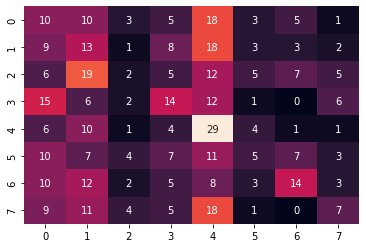

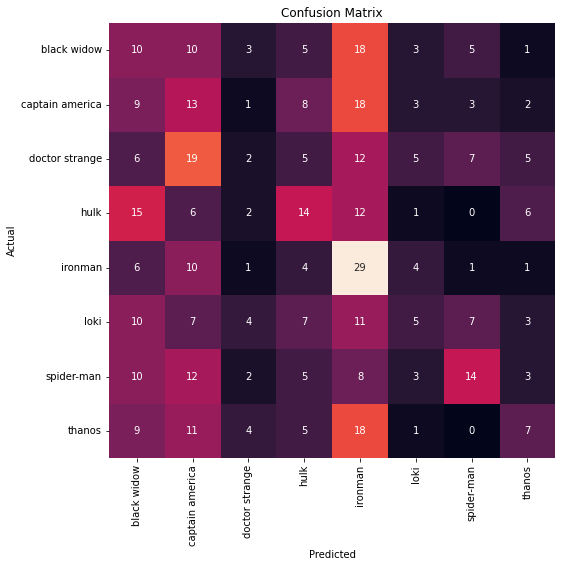

Classification Report:
----------------------
                  precision    recall  f1-score   support

    black widow       0.13      0.18      0.15        55
captain america       0.15      0.23      0.18        57
 doctor strange       0.11      0.03      0.05        61
           hulk       0.26      0.25      0.26        56
        ironman       0.23      0.52      0.32        56
           loki       0.20      0.09      0.13        54
     spider-man       0.38      0.25      0.30        57
         thanos       0.25      0.13      0.17        55

       accuracy                           0.21       451
      macro avg       0.21      0.21      0.19       451
   weighted avg       0.21      0.21      0.19       451



In [86]:
# def showconfusionmatrix(cm):
#     pl.matshow(cm)
#     pl.title('Confusion matrix')
#     pl.colorbar()
#     pl.values()
#     pl.show()


accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions)
print (cm)

# showconfusionmatrix(cm)

################# sreeni ###########################
"""
#For classification of unknown files we can print the predictions
#Print the Predictions 
print ("Image =", image_paths)
print ("prediction ="  + str(predictions))
#np.transpose to save data into columns, otherwise saving as rows
np.savetxt ('mydata.csv', np.transpose([image_paths, predictions]),fmt='%s', delimiter=',', newline='\n')
"""
cf_matrix = confusion_matrix(meow, meow2)
# print(cf_matrix)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cf_matrix, annot=True, fmt='g', vmin=0, cbar=False)

# results = model.evaluate(test_images, verbose=0)
# predictions = np.argmax(model.predict(test_images), axis=1)

class_names = list(np.unique(meow))

# cm = confusion_matrix(meow, meow2, labels=np.arange(8))
clr = classification_report(meow, meow2, labels=list(np.unique(meow)), target_names=class_names)
# 
# print("Test Accuracy: {:.2f}%".format(results[1] * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0,  cbar=False)
plt.xticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)